In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Setup spark session

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Postgres and Snowflake") \
    .config("spark.jars.packages",
            "net.snowflake:spark-snowflake_2.12:2.11.0-spark_3.3,"
            "net.snowflake:snowflake-jdbc:3.13.22") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.memoryOverhead", "2g") \
    .getOrCreate()

:: loading settings :: url = jar:file:/home/hadoop/spark-3.5.5-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/hadoop/.ivy2/cache
The jars for the packages stored in: /home/hadoop/.ivy2/jars
net.snowflake#spark-snowflake_2.12 added as a dependency
net.snowflake#snowflake-jdbc added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b5ca1df6-1658-48c2-aa11-1841b27add1b;1.0
	confs: [default]
	found net.snowflake#spark-snowflake_2.12;2.11.0-spark_3.3 in central
	found net.snowflake#snowflake-ingest-sdk;0.10.8 in central
	found net.snowflake#snowflake-jdbc;3.13.22 in central
:: resolution report :: resolve 199ms :: artifacts dl 5ms
	:: modules in use:
	net.snowflake#snowflake-ingest-sdk;0.10.8 from central in [default]
	net.snowflake#snowflake-jdbc;3.13.22 from central in [default]
	net.snowflake#spark-snowflake_2.12;2.11.0-spark_3.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|d

In [3]:
from dotenv import load_dotenv
import os

dotenv_path = os.path.abspath("../../spark/.env")
load_dotenv(dotenv_path=dotenv_path)
#snowflake conector config
sfOptions = {
    "sfURL": os.getenv("SF_URL"),
    "sfUser": os.getenv("SF_USER"),
    "sfPassword": os.getenv("SF_PASSWORD"),
    "sfDatabase": os.getenv("SF_DATABASE"),
    "sfSchema": os.getenv("SF_SCHEMA"),
    "sfWarehouse": os.getenv("SF_WAREHOUSE"),
    "sfRole": os.getenv("SF_ROLE"),
    "insecureMode": "true"
}

### Exploratory Data Analysis

In [5]:
df = spark.read \
    .format("snowflake") \
    .options(**sfOptions) \
    .option("dbtable", "SALES_ANALYTICS.PUBLIC.MONTHLY_REVENUE_PROFIT") \
    .load()

df.show()

25/06/04 23:04:43 WARN SnowflakeConnectorUtils$: Query pushdown is not supported because you are using Spark 3.5.5 with a connector designed to support Spark 3.3. Either use the version of Spark supported by the connector or install a version of the connector that supports your version of Spark.


+----------+--------------------+------------------+
|     MONTH|       TOTAL_REVENUE|      TOTAL_PROFIT|
+----------+--------------------+------------------+
|2016-07-31|        6.25174137E7|     1.151157555E7|
|2016-08-31|5.8620393089999996E7|     1.096006947E7|
|2016-09-30|       3.700957113E7|        6947049.62|
|2016-10-31|2.9358311220000003E7| 5640555.550000001|
|2016-11-30|       2.033400915E7|        3893238.64|
|2016-12-31|2.3209091009999998E7|        4581453.17|
|2017-01-31|         2.0726811E7|        3762316.39|
|2017-02-28|2.6263589939999998E7|        4782356.24|
|2017-03-31|       3.335273298E7| 6050520.890000001|
|2017-04-30|       4.554365382E7| 8101091.350000001|
|2017-05-31|       4.262598648E7|        7793814.24|
|2017-06-30|       4.126022334E7|        7280303.82|
|2017-07-31|       3.377494701E7|        6239033.47|
|2017-08-31|       4.266063396E7|8086754.5200000005|
|2017-09-30|       2.637974682E7| 4845988.720000001|
|2017-10-31|       2.139435648E7|3846817.36000

In [6]:
df_monthly = df.toPandas()
df_monthly.set_index('MONTH', inplace=True)
df_monthly.index = pd.to_datetime(df_monthly.index)
df_monthly.head()

,TOTAL_REVENUE,TOTAL_PROFIT
MONTH,,
2016-07-31,62517413.70,11511575.55
2016-08-31,58620393.09,10960069.47
2016-09-30,37009571.13,6947049.62
2016-10-31,29358311.22,5640555.55
2016-11-30,20334009.15,3893238.64


In [8]:
df_monthly.sort_index(inplace=True)
df_monthly.head()

,TOTAL_REVENUE,TOTAL_PROFIT
MONTH,,
2010-08-31,47303856.18,8974623.31
2010-09-30,34881766.29,6510791.89
2010-10-31,32132565.36,5843810.08
2010-11-30,27462497.58,5002567.21
2010-12-31,32303821.41,5897933.77


#### Monthly trends

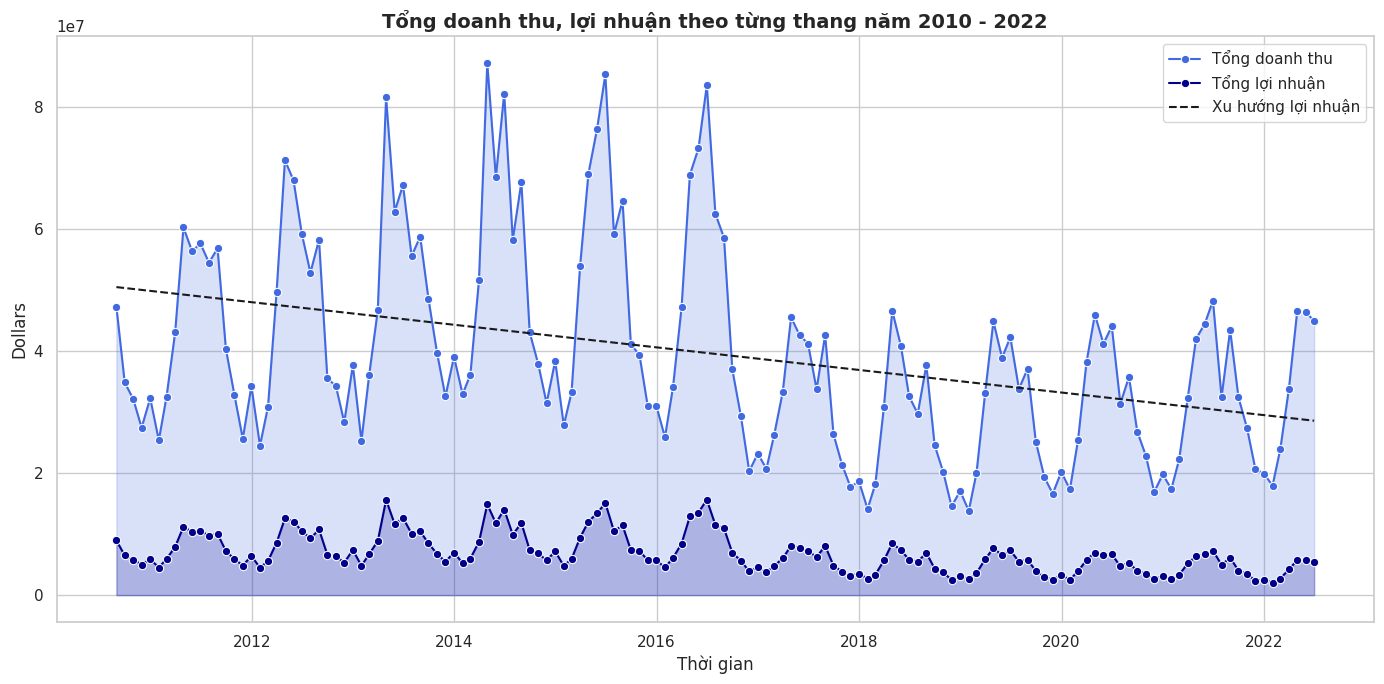

In [19]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 7))

# Vẽ doanh thu và lợi nhuận
sns.lineplot(x=df_monthly.index, y=df_monthly['TOTAL_REVENUE'], label='Tổng doanh thu', marker='o', color='royalblue')
sns.lineplot(x=df_monthly.index, y=df_monthly['TOTAL_PROFIT'], label='Tổng lợi nhuận', marker='o', color='darkblue')

# Đổ bóng (area)
plt.fill_between(df_monthly.index, df_monthly['TOTAL_REVENUE'], alpha=0.2, color='royalblue')
plt.fill_between(df_monthly.index, df_monthly['TOTAL_PROFIT'], alpha=0.2, color='darkblue')

# Thêm đường xu hướng cho lợi nhuận
x = (df_monthly.index - df_monthly.index[0]).days  # chuyển datetime thành số ngày
z = np.polyfit(x, df_monthly['TOTAL_REVENUE'], 1)
p = np.poly1d(z)

# Sau đó vẽ đường xu hướng
plt.plot(df_monthly.index, p(x), 'k--', label='Xu hướng lợi nhuận')

# Tùy chỉnh
plt.title('Tổng doanh thu, lợi nhuận theo từng thang năm 2010 - 2022', fontsize=14, weight='bold')
plt.xlabel('Thời gian')
plt.ylabel('Dollars')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
years = df_monthly.index.year.unique()
monthly_data_by_year = {year: df_monthly[df_monthly.index.year == year]['TOTAL_PROFIT'].resample('M').mean() for year in years}
monthly_avg = df_monthly['TOTAL_PROFIT'].resample('M').mean().groupby(df_monthly.index.month).mean()

/tmp/ipykernel_38881/686626310.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data_by_year = {year: df_monthly[df_monthly.index.year == year]['TOTAL_PROFIT'].resample('M').mean() for year in years}
/tmp/ipykernel_38881/686626310.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_monthly['TOTAL_PROFIT'].resample('M').mean().groupby(df_monthly.index.month).mean()


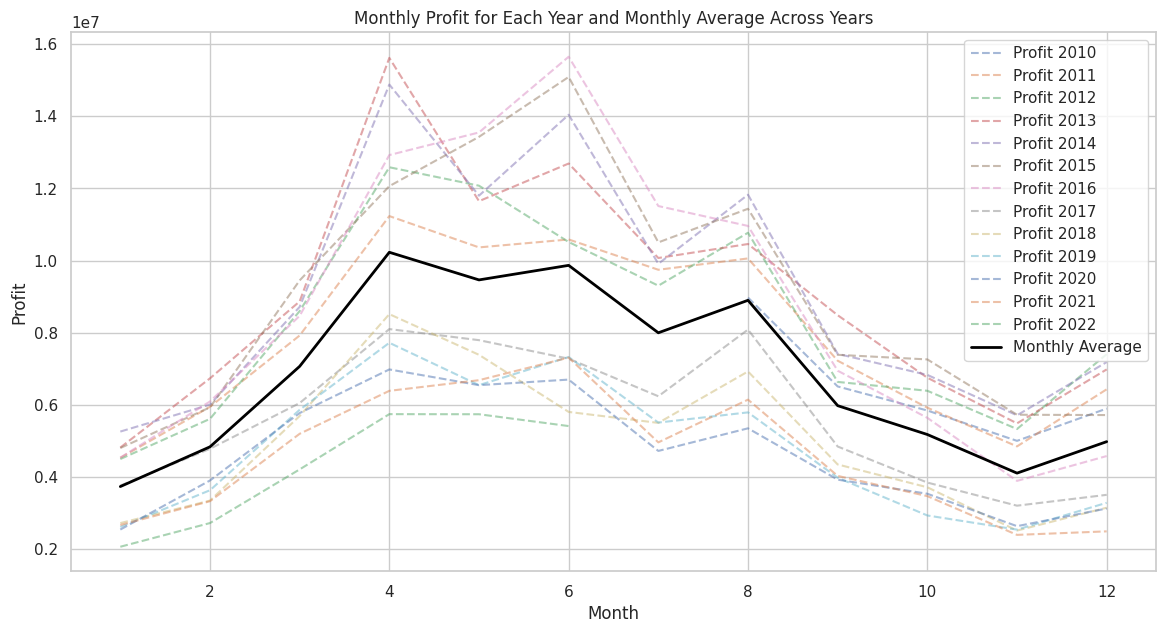

In [ ]:
plt.figure(figsize=(14, 7))

# Vẽ đường cho mỗi năm
for year, data in monthly_data_by_year.items():
    plt.plot(data.index.month, data.values, label=f'Profit {year}', alpha=0.5, linestyle='--')  # Các đường mờ

# Vẽ đường trung bình hàng tháng cho tất cả các năm
plt.plot(monthly_avg.index, monthly_avg.values, label='Monthly Average', color='black', linewidth=2)  # Đường đậm

plt.title('Monthly Profit for Each Year and Monthly Average Across Years')
plt.xlabel('Month')
plt.ylabel('Profit')
plt.legend()
plt.grid(True)
plt.show()


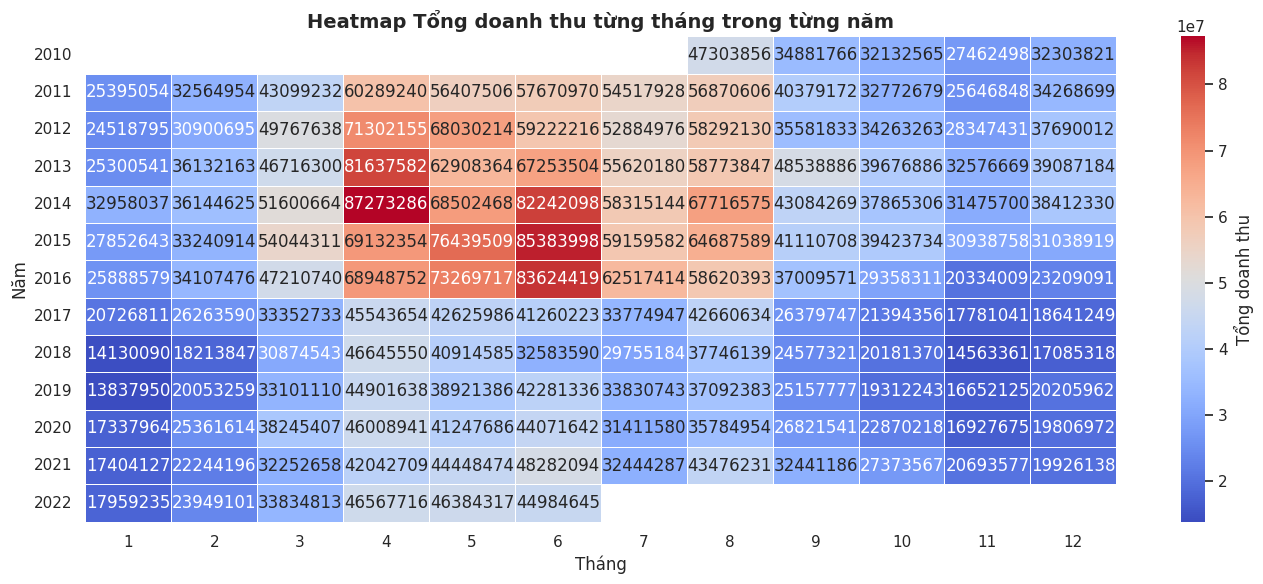

In [27]:
# Thêm cột Năm và Tháng
df_monthly['Year'] = df_monthly.index.year
df_monthly['Month'] = df_monthly.index.month

# Pivot lại dữ liệu để tạo ma trận cho heatmap
heatmap_data = df_monthly.pivot(index='Year', columns='Month', values='TOTAL_REVENUE')

# Vẽ Heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    annot=True,
    fmt='.0f',
    linewidths=0.5,
    cbar_kws={'label': 'Tổng doanh thu'},
)


plt.title('Heatmap Tổng doanh thu từng tháng trong từng năm', fontsize=14, weight='bold')
plt.xlabel('Tháng')
plt.ylabel('Năm')
plt.grid(False)
plt.tight_layout()
plt.show()

#### Quarter trends

In [ ]:
df_quarter = spark.read \
    .format("snowflake") \
    .options(**sfOptions) \
    .option("dbtable", "SALES_ANALYTICS.PUBLIC.QUARTERLY_REVENUE_PROFIT") \
    .load()

df_quarter.show()

25/06/04 23:18:34 WARN SnowflakeConnectorUtils$: Query pushdown is not supported because you are using Spark 3.5.5 with a connector designed to support Spark 3.3. Either use the version of Spark supported by the connector or install a version of the connector that supports your version of Spark.


+----------+--------------------+--------------------+
|   QUARTER|       TOTAL_REVENUE|        TOTAL_PROFIT|
+----------+--------------------+--------------------+
|2016-07-01|      1.5814737792E8|       2.941869464E7|
|2016-10-01|       7.290141138E7|       1.411524736E7|
|2017-01-01|       8.034313392E7|       1.459519352E7|
|2017-04-01|      1.2942986364E8|2.3175209410000004E7|
|2017-07-01|1.0281532778999999E8|       1.917177671E7|
|2017-10-01|       5.781664665E7|1.0559266370000001E7|
|2018-01-01|6.3218480849999994E7|1.1760817450000001E7|
|2018-04-01|      1.2014372412E8|2.1708209900000002E7|
|2018-07-01|       9.207864351E7|       1.677509946E7|
|2018-10-01|       5.183004897E7|          9381833.24|
|2019-01-01|       6.699231882E7|1.2112463520000001E7|
|2019-04-01|       1.261043595E8|       2.159581927E7|
|2019-07-01| 9.608090310000001E7|1.5282489560000002E7|
|2019-10-01|       5.617032939E7|   8762839.830000002|
|2020-01-01|       8.094498489E7|1.2222169360000003E7|
|2020-04-0

In [15]:
df_quarter = df_quarter.toPandas()
df_quarter.set_index('QUARTER', inplace=True)
df_quarter.index = pd.to_datetime(df_quarter.index)
df_quarter.head()

,TOTAL_REVENUE,TOTAL_PROFIT
QUARTER,,
2016-07-01,1.581474e+08,29418694.64
2016-10-01,7.290141e+07,14115247.36
2017-01-01,8.034313e+07,14595193.52
2017-04-01,1.294299e+08,23175209.41
2017-07-01,1.028153e+08,19171776.71


In [16]:
df_quarter.sort_index(inplace=True)
df_quarter.head()

,TOTAL_REVENUE,TOTAL_PROFIT
QUARTER,,
2010-07-01,1.185376e+08,22893695.56
2010-10-01,9.189888e+07,16744311.06
2011-01-01,1.010592e+08,18402520.18
2011-04-01,1.743677e+08,32184167.19
2011-07-01,1.517677e+08,27029159.61


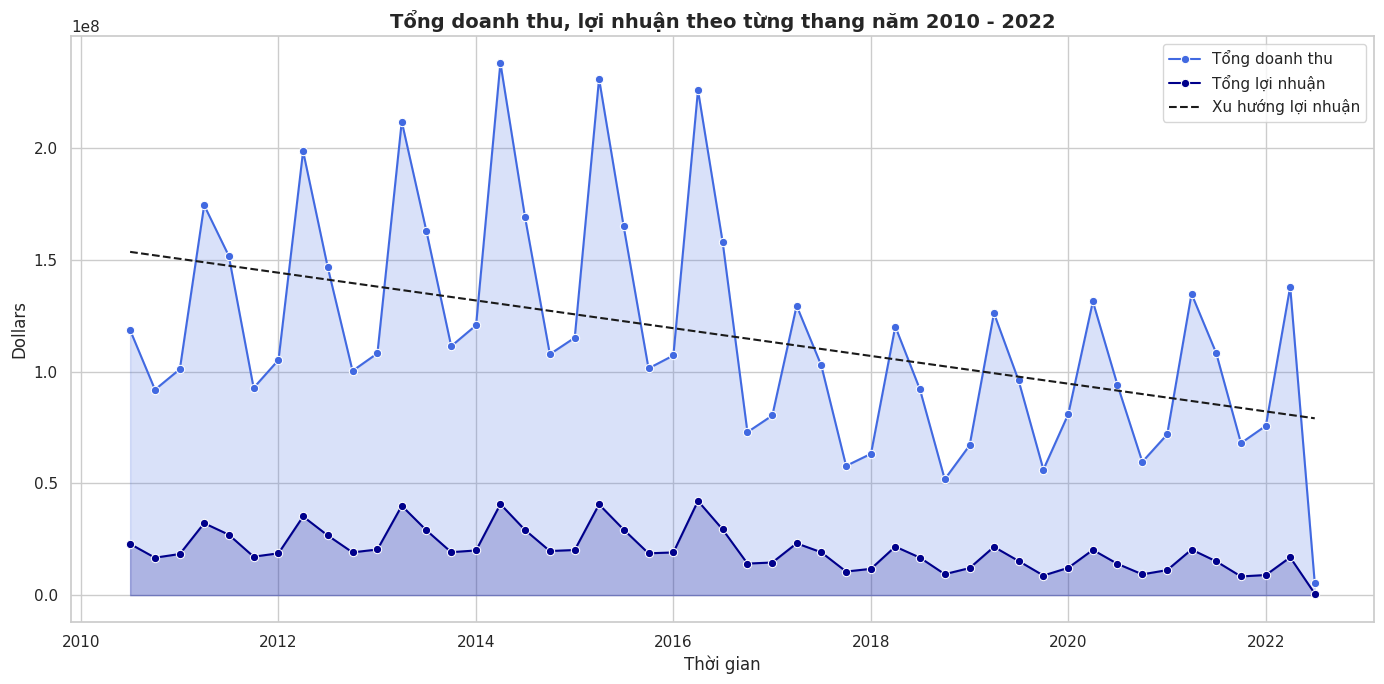

In [17]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 7))

# Vẽ doanh thu và lợi nhuận
sns.lineplot(x=df_quarter.index, y=df_quarter['TOTAL_REVENUE'], label='Tổng doanh thu', marker='o', color='royalblue')
sns.lineplot(x=df_quarter.index, y=df_quarter['TOTAL_PROFIT'], label='Tổng lợi nhuận', marker='o', color='darkblue')

# Đổ bóng (area)
plt.fill_between(df_quarter.index, df_quarter['TOTAL_REVENUE'], alpha=0.2, color='royalblue')
plt.fill_between(df_quarter.index, df_quarter['TOTAL_PROFIT'], alpha=0.2, color='darkblue')

# Thêm đường xu hướng cho lợi nhuận
x = (df_quarter.index - df_quarter.index[0]).days  # chuyển datetime thành số ngày
z = np.polyfit(x, df_quarter['TOTAL_REVENUE'], 1)
p = np.poly1d(z)

# Sau đó vẽ đường xu hướng
plt.plot(df_quarter.index, p(x), 'k--', label='Xu hướng lợi nhuận')

# Tùy chỉnh
plt.title('Tổng doanh thu, lợi nhuận theo từng thang năm 2010 - 2022', fontsize=14, weight='bold')
plt.xlabel('Thời gian')
plt.ylabel('Dollars')
plt.legend()
plt.tight_layout()
plt.show()

### Factors Impacting Business Performance

There are several factors that impact business performance. These include: geography, product segmentation and classification, customer segmentation and classification, and product lines.

#### Geography

In [ ]:
df_state = spark.read \
    .format("snowflake") \
    .options(**sfOptions) \
    .option("dbtable", "SALES_ANALYTICS.PUBLIC.REVENUE_PROFIT_STATE") \
    .load()
z   
df_state.show()

25/06/05 00:03:34 WARN SnowflakeConnectorUtils$: Query pushdown is not supported because you are using Spark 3.5.5 with a connector designed to support Spark 3.3. Either use the version of Spark supported by the connector or install a version of the connector that supports your version of Spark.


+-----+--------------------+--------------------+
|STATE|       TOTAL_REVENUE|        TOTAL_PROFIT|
+-----+--------------------+--------------------+
|   IL|2.1686962878000003E8|       3.712832031E7|
|   WA|      1.5273091638E8|       2.709837809E7|
|   NC|      1.6927028181E8|2.9176006349999998E7|
|   MA|       6.426535248E7|       1.164454083E7|
|   WI|      1.4678870409E8|       2.567737693E7|
|   IN|1.2854967803999999E8|2.2077211400000002E7|
|   TX|      4.1900711706E8| 7.084736930000001E7|
|   OH|      2.3521727376E8| 4.033753643000001E7|
|   SD|       2.656629297E7|          4589382.14|
|   NJ|      1.2171033945E8|       2.096225704E7|
|   SC|       7.689506265E7|1.2862179290000001E7|
|   DE|        1.86093621E7|          3269417.45|
|   MD| 9.658376910000001E7|       1.704613928E7|
|   AR|       5.867745156E7|          9884972.35|
|   NM|5.0276991239999995E7|          8573077.75|
|   ID|       4.867729713E7|          8395063.32|
|   NE|       3.878435862E7|   6682062.710000001|


In [5]:
df_state = df_state.toPandas()

In [6]:
import plotly.express as px
# Vẽ bản đồ
fig = px.choropleth(
    df_state,
    locations='STATE',  # cột mã bang
    locationmode='USA-states',  # kiểu mã bang
    color='TOTAL_REVENUE',  # cột dùng để tô màu
    scope='usa',  # chỉ vẽ nước Mỹ
    color_continuous_scale='RdYlBu_r',  # thang màu
    labels={'TOTAL_REVENUE': 'Doanh thu'},
    title='Tổng doanh thu nước Mỹ theo từng khu vực'
)

fig.update_layout(
    title_x=0.5,
    geo=dict(showlakes=False),  # bỏ các hồ lớn
    font=dict(family="Arial", size=14)
)

fig.show()

In [12]:
df_region = spark.read \
    .format("snowflake") \
    .options(**sfOptions) \
    .option("dbtable", "SALES_ANALYTICS.PUBLIC.REGION_SALES") \
    .load()

df_region.show()

25/06/05 00:09:01 WARN SnowflakeConnectorUtils$: Query pushdown is not supported because you are using Spark 3.5.5 with a connector designed to support Spark 3.3. Either use the version of Spark supported by the connector or install a version of the connector that supports your version of Spark.


+-------+--------------------+
| REGION|       TOTAL_REVENUE|
+-------+--------------------+
|   West|     1.32720026229E9|
|   East|2.6508716501400003E9|
|Central|1.7203195957500002E9|
+-------+--------------------+



In [14]:
df_region = df_region.toPandas()

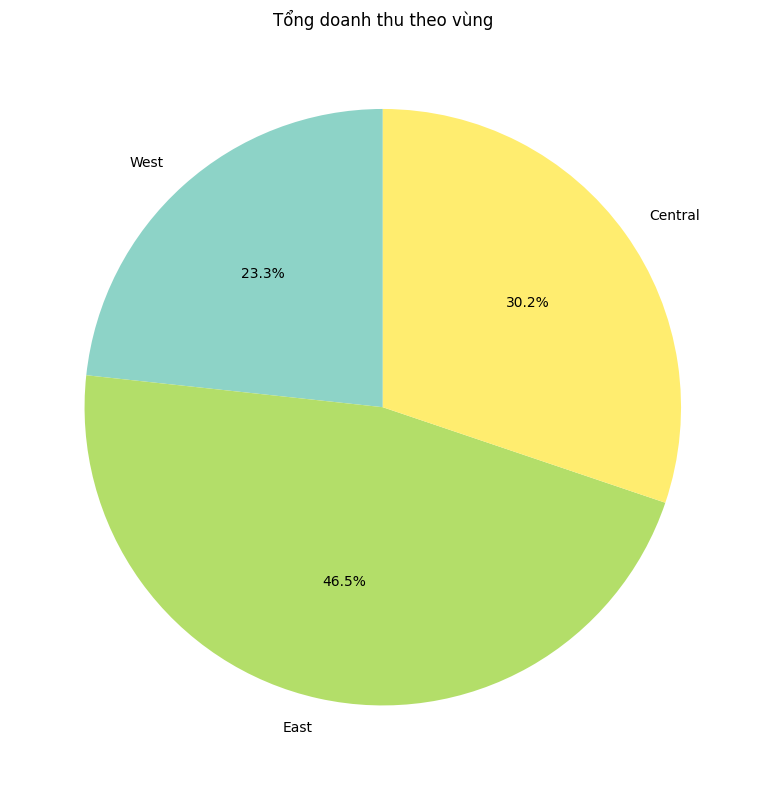

In [15]:
df_region.set_index('REGION')['TOTAL_REVENUE'].plot(
    kind='pie',
    autopct='%1.1f%%',  # hiện phần trăm
    figsize=(8, 8),
    startangle=90,
    cmap='Set3'
)

plt.ylabel('')  # bỏ nhãn trục y
plt.title('Tổng doanh thu theo vùng')  # tiêu đề
plt.tight_layout()
plt.show()

In [21]:
df_top = spark.read \
    .format("snowflake") \
    .options(**sfOptions) \
    .option("dbtable", "SALES_ANALYTICS.PUBLIC.TOP_STATES_BY_REVENUE_PROFIT") \
    .load()

df_top.show()

25/06/05 00:37:24 WARN SnowflakeConnectorUtils$: Query pushdown is not supported because you are using Spark 3.5.5 with a connector designed to support Spark 3.3. Either use the version of Spark supported by the connector or install a version of the connector that supports your version of Spark.


+-----+------------------+--------------------+------------+
|STATE|     TOTAL_REVENUE|        TOTAL_PROFIT|RANK_REVENUE|
+-----+------------------+--------------------+------------+
|   AK|     1.794167487E7|          3109539.12|          45|
|   RI|     1.772762544E7|  3116943.7300000004|          46|
|   VT|        4111349.13|   742477.0800000001|          47|
|   NH|        3524395.77|           684667.24|          48|
|   DC|2695183.4699999997|  479196.26999999996|          49|
|   CA|    6.8800233159E8|       1.265530137E8|           1|
|   TX|    4.1900711706E8| 7.084736930000001E7|           2|
|   FL|    4.0559591142E8|       6.709190067E7|           3|
|   PA|    2.5603072929E8|4.4431081239999995E7|           4|
|   OH|    2.3521727376E8| 4.033753643000001E7|           5|
+-----+------------------+--------------------+------------+



In [22]:
df = df_top.toPandas()
df.head()

,STATE,TOTAL_REVENUE,TOTAL_PROFIT,RANK_REVENUE
0,AK,17941674.87,3109539.12,45
1,RI,17727625.44,3116943.73,46
2,VT,4111349.13,742477.08,47
3,NH,3524395.77,684667.24,48
4,DC,2695183.47,479196.27,49


In [29]:

df_low = df[df['STATE'].isin(['CA', 'TX', 'FL', 'PA', 'OH'])].reset_index(drop=True)
df_high = df.loc[df['STATE'].isin(['AK', 'RI', 'VT', 'NH', 'DC'])].reset_index(drop=True)

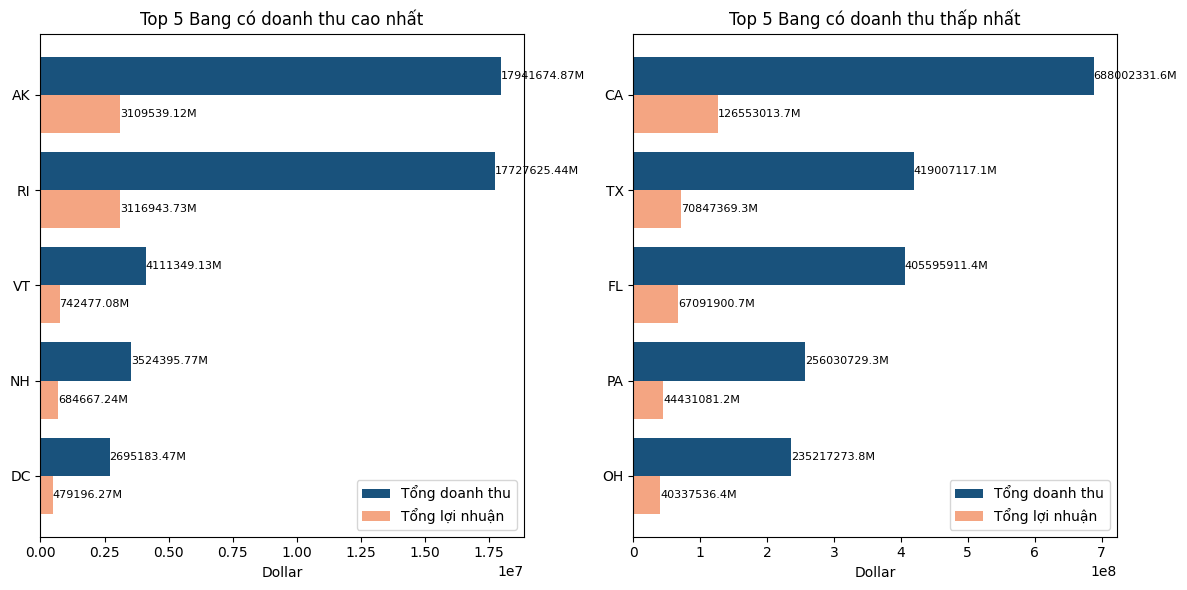

In [31]:
# Thiết lập vị trí và chiều cao thanh
y = np.arange(len(df_high))
bar_height = 0.4

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# === Biểu đồ trái: doanh thu cao ===
ax = axes[0]
ax.barh(y - bar_height/2, df_high['TOTAL_REVENUE'], height=bar_height, label='Tổng doanh thu', color='#19527c')
ax.barh(y + bar_height/2, df_high['TOTAL_PROFIT'], height=bar_height, label='Tổng lợi nhuận', color='#f4a582')
ax.set_yticks(y)
ax.set_yticklabels(df_high['STATE'])
ax.invert_yaxis()
ax.set_xlabel('Dollar')
ax.set_title('Top 5 Bang có doanh thu cao nhất')
ax.legend()
for i in range(len(df_high)):
    ax.text(df_high['TOTAL_REVENUE'][i] + 0.01, y[i] - bar_height/2, f"{df_high['TOTAL_REVENUE'][i]:.2f}M", va='center', fontsize=8)
    ax.text(df_high['TOTAL_PROFIT'][i] + 0.005, y[i] + bar_height/2, f"{df_high['TOTAL_PROFIT'][i]:.2f}M", va='center', fontsize=8)

# === Biểu đồ phải: doanh thu thấp ===
y2 = np.arange(len(df_low))
ax = axes[1]
ax.barh(y2 - bar_height/2, df_low['TOTAL_REVENUE'], height=bar_height, label='Tổng doanh thu', color='#19527c')
ax.barh(y2 + bar_height/2, df_low['TOTAL_PROFIT'], height=bar_height, label='Tổng lợi nhuận', color='#f4a582')
ax.set_yticks(y2)
ax.set_yticklabels(df_low['STATE'])
ax.invert_yaxis()
ax.set_xlabel('Dollar')
ax.set_title('Top 5 Bang có doanh thu thấp nhất')
ax.legend()
for i in range(len(df_low)):
    ax.text(df_low['TOTAL_REVENUE'][i] + 0.2, y2[i] - bar_height/2, f"{df_low['TOTAL_REVENUE'][i]:.1f}M", va='center', fontsize=8)
    ax.text(df_low['TOTAL_PROFIT'][i] + 0.2, y2[i] + bar_height/2, f"{df_low['TOTAL_PROFIT'][i]:.1f}M", va='center', fontsize=8)

plt.tight_layout()

#### product segmentation and classification

In [46]:
df_segment = spark.read \
    .format("snowflake") \
    .options(**sfOptions) \
    .option("dbtable", "SALES_ANALYTICS.PUBLIC.SEGMENT_PROFIT_TOP5_STATES") \
    .load()

df_segment.show()

25/06/05 01:03:04 WARN SnowflakeConnectorUtils$: Query pushdown is not supported because you are using Spark 3.5.5 with a connector designed to support Spark 3.3. Either use the version of Spark supported by the connector or install a version of the connector that supports your version of Spark.


+-----+--------+-------------------+
|STATE|CATEGORY|       TOTAL_PROFIT|
+-----+--------+-------------------+
|   FL|   Urban|      5.669252219E7|
|   TX|   Rural|  8105759.219999999|
|   TX|   Urban|6.032165263000001E7|
|   RI|   Urban| 2616494.9000000004|
|   OH|   Urban|      3.413912939E7|
|   PA|   Urban|       3.68665083E7|
|   AK|   Urban|         2267838.88|
|   VT|   Urban|  571296.1900000001|
|   TX|   Youth| 1471965.2599999998|
|   OH|   Rural|  4825237.559999999|
|   FL|     Mix| 1198173.4499999997|
|   CA|   Youth| 3067358.6999999993|
|   FL|   Youth| 2442804.5399999996|
|   NH|   Rural| 105056.96999999999|
|   VT|     Mix|           40165.56|
|   NH|     Mix|           13196.46|
|   DC|     Mix|  24084.30999999999|
|   CA|   Urban|      8.267849162E7|
|   TX|     Mix|  947992.1899999998|
|   CA|   Rural|3.655457174999999E7|
+-----+--------+-------------------+
only showing top 20 rows



In [52]:
df = df_segment.toPandas()
df_high = df[df['STATE'].isin(['CA', 'TX', 'FL', 'PA', 'OH'])].reset_index(drop=True)
df_low = df.loc[df['STATE'].isin(['AK', 'RI', 'VT', 'NH', 'DC'])].reset_index(drop=True)

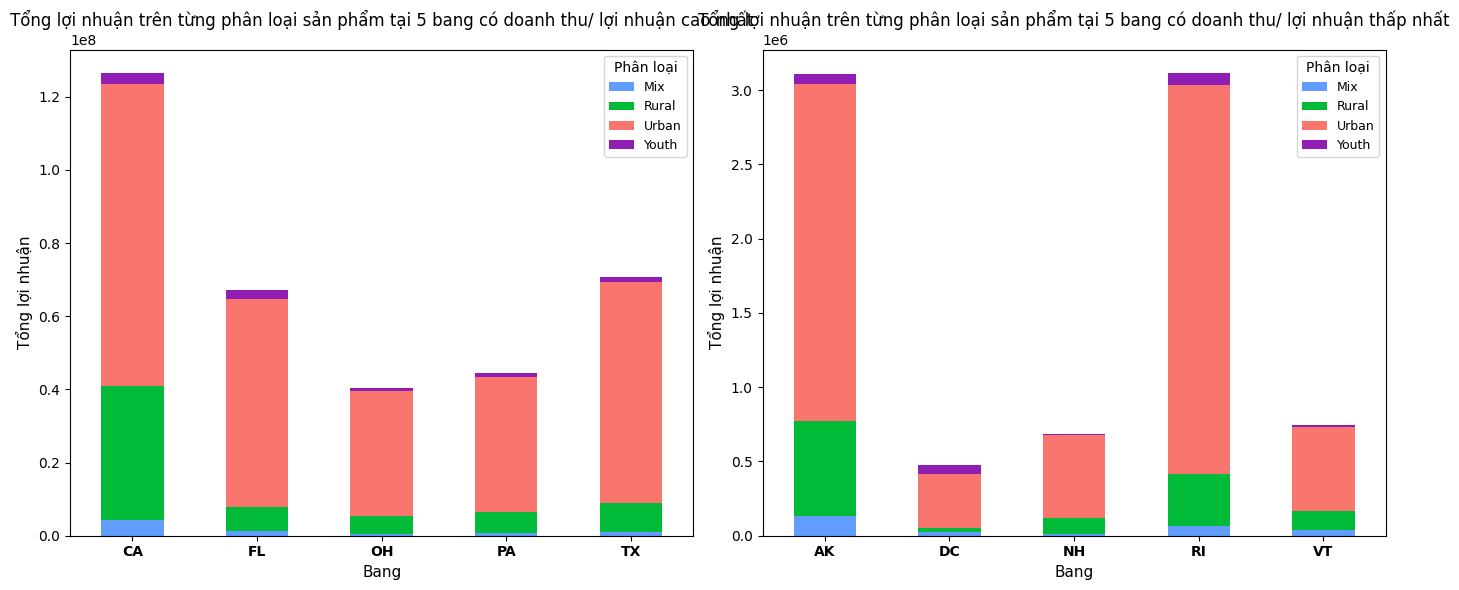

In [53]:
# Thiết lập font tiếng Việt nếu cần
plt.rcParams['font.family'] = 'DejaVu Sans'

# Tạo figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
bar_height = 0.6

# Chọn bảng màu
colors = {
    'Mix': '#619CFF',
    'Rural': '#00BA38',
    'Urban': '#F8766D',
    'Youth': '#911eb4'
}

# --- Biểu đồ trái: df_high ---
ax = axes[0]
df_pivot_high = df_high.pivot_table(index='STATE', columns='CATEGORY', values='TOTAL_PROFIT', aggfunc='sum').fillna(0)
df_pivot_high = df_pivot_high[colors.keys()]  # Đảm bảo đúng thứ tự màu
df_pivot_high.plot(kind='bar', stacked=True, color=[colors[i] for i in df_pivot_high.columns], ax=ax)

ax.set_title("Tổng lợi nhuận trên từng phân loại sản phẩm tại 5 bang có doanh thu/ lợi nhuận cao nhất", fontsize=12)
ax.set_ylabel("Tổng lợi nhuận", fontsize=11)
ax.set_xlabel("Bang", fontsize=11)
ax.legend(title="Phân loại", title_fontsize=10, fontsize=9)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontweight='bold')

# --- Biểu đồ phải: df_low ---
ax = axes[1]
df_pivot_low = df_low.pivot_table(index='STATE', columns='CATEGORY', values='TOTAL_PROFIT', aggfunc='sum').fillna(0)
df_pivot_low = df_pivot_low[colors.keys()]
df_pivot_low.plot(kind='bar', stacked=True, color=[colors[i] for i in df_pivot_low.columns], ax=ax)

ax.set_title("Tổng lợi nhuận trên từng phân loại sản phẩm tại 5 bang có doanh thu/ lợi nhuận thấp nhất", fontsize=12)
ax.set_ylabel("Tổng lợi nhuận", fontsize=11)
ax.set_xlabel("Bang", fontsize=11)
ax.legend(title="Phân loại", title_fontsize=10, fontsize=9)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontweight='bold')

plt.tight_layout()
plt.show()

In [54]:
category_sales = spark.read \
    .format("snowflake") \
    .options(**sfOptions) \
    .option("dbtable", "SALES_ANALYTICS.PUBLIC.CATEGORY_SALES") \
    .load()

segment_sales = spark.read \
    .format("snowflake") \
    .options(**sfOptions) \
    .option("dbtable", "SALES_ANALYTICS.PUBLIC.SEGMENT_SALES") \
    .load()

25/06/05 01:14:06 WARN SnowflakeConnectorUtils$: Query pushdown is not supported because you are using Spark 3.5.5 with a connector designed to support Spark 3.3. Either use the version of Spark supported by the connector or install a version of the connector that supports your version of Spark.
25/06/05 01:14:07 WARN SnowflakeConnectorUtils$: Query pushdown is not supported because you are using Spark 3.5.5 with a connector designed to support Spark 3.3. Either use the version of Spark supported by the connector or install a version of the connector that supports your version of Spark.


In [55]:
category_sales=category_sales.toPandas()
segment_sales=segment_sales.toPandas()

In [56]:
category_sales.head()

,CATEGORY,TOTAL_REVENUE,TOTAL_PROFIT
0,Mix,1.691827e+08,1.980930e+07
1,Urban,4.596156e+09,7.838377e+08
2,Rural,8.169702e+08,1.592731e+08
3,Youth,1.160826e+08,2.531190e+07


In [57]:
segment_sales.head()

,SEGMENT,TOTAL_REVENUE,TOTAL_PROFIT
0,Extreme,8.083372e+08,1.235663e+08
1,Select,1.737339e+08,2.460433e+07
2,Convenience,1.784850e+09,3.272315e+08
3,Productivity,6.534466e+08,1.371551e+08
4,Moderation,1.917690e+09,3.144107e+08


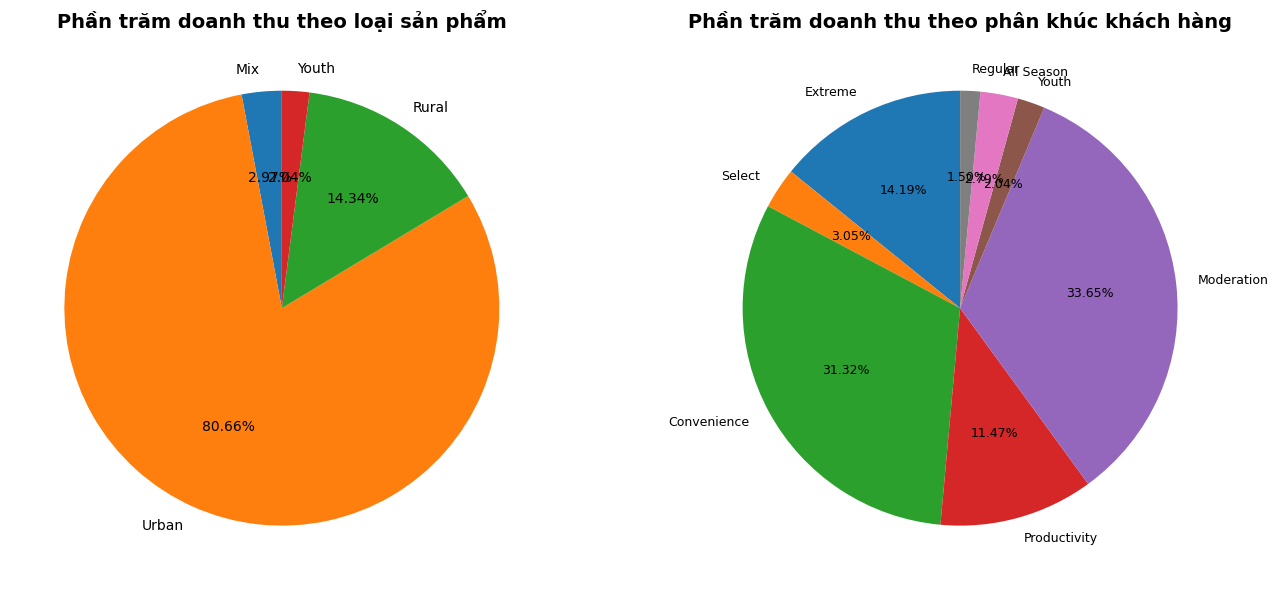

In [59]:
plt.rcParams['font.family'] = 'DejaVu Sans'
# Tạo figure với 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Pie 1: Phân loại sản phẩm ---
axes[0].pie(
    category_sales['TOTAL_REVENUE'], labels=category_sales['CATEGORY'], autopct='%1.2f%%',
    startangle=90, textprops={'fontsize': 10}
)
axes[0].set_title("Phần trăm doanh thu theo loại sản phẩm", fontsize=14, fontweight='bold')

# --- Pie 2: Phân khúc khách hàng ---
wedges, texts, autotexts = axes[1].pie(
    segment_sales['TOTAL_REVENUE'], labels=segment_sales['SEGMENT'], autopct='%1.2f%%',
    startangle=90, textprops={'fontsize': 9}
)
axes[1].set_title("Phần trăm doanh thu theo phân khúc khách hàng", fontsize=14, fontweight='bold')

# Thêm legend gọn gàng (chỉ nếu cần thiết)
# axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

#### Product lines

In [60]:
product_lines = spark.read \
    .format("snowflake") \
    .options(**sfOptions) \
    .option("dbtable", "SALES_ANALYTICS.PUBLIC.PRODUCT_PROFIT_ANALYSIS") \
    .load()

product_lines.show()

25/06/05 01:19:56 WARN SnowflakeConnectorUtils$: Query pushdown is not supported because you are using Spark 3.5.5 with a connector designed to support Spark 3.3. Either use the version of Spark supported by the connector or install a version of the connector that supports your version of Spark.


+----------+--------------+------------------+
|PRODUCT_ID|       PRODUCT|      TOTAL_PROFIT|
+----------+--------------+------------------+
|      1340|  Quibus RP-32|           63765.7|
|       196|   Abbas UC-08| 63101.70000000001|
|      1707|  Salvus YY-18| 62673.23999999995|
|       385|    Fama UE-06| 61747.04000000002|
|      1112|   Pirum RP-58|60888.559999999976|
|       956|  Natura UC-19| 60718.83000000016|
|       353|    Fama UE-74| 60708.00999999998|
|      1941|  Currus RP-16|60472.669999999984|
|      2119|Victoria UM-10|60070.080000000045|
|      1095|   Pirum RP-41| 59718.49999999992|
|      1429|  Quibus RP-21| 59105.77999999999|
|      1838|   Pomum YY-33|59098.619999999966|
|      1382|  Quibus RP-74|58048.149999999994|
|       368|    Fama UE-89| 58046.90000000001|
|      1684|  Quibus UE-14| 58029.59999999999|
|      1279|  Quibus MA-15|          57776.25|
|      1390|  Quibus RP-82|57690.989999999976|
|      1076|   Pirum RP-22|          57314.92|
|       174| 

In [61]:
product_lines = product_lines.toPandas()

In [63]:
product_lines['BRAND'] = product_lines['PRODUCT'].str.split().str[0]

product_lines_grouped = product_lines.groupby('BRAND', as_index=False)['TOTAL_PROFIT'].sum()
product_lines_grouped = product_lines_grouped.sort_values(by='TOTAL_PROFIT', ascending=False)

In [64]:
product_lines_grouped

,BRAND,TOTAL_PROFIT
6,Maximus,4.435604e+08
7,Natura,1.545325e+08
1,Aliqui,1.193716e+08
3,Currus,8.047714e+07
9,Pirum,7.222288e+07
11,Quibus,2.863243e+07
0,Abbas,2.365769e+07
4,Fama,1.607563e+07
5,Leo,1.324414e+07
2,Barba,1.261533e+07


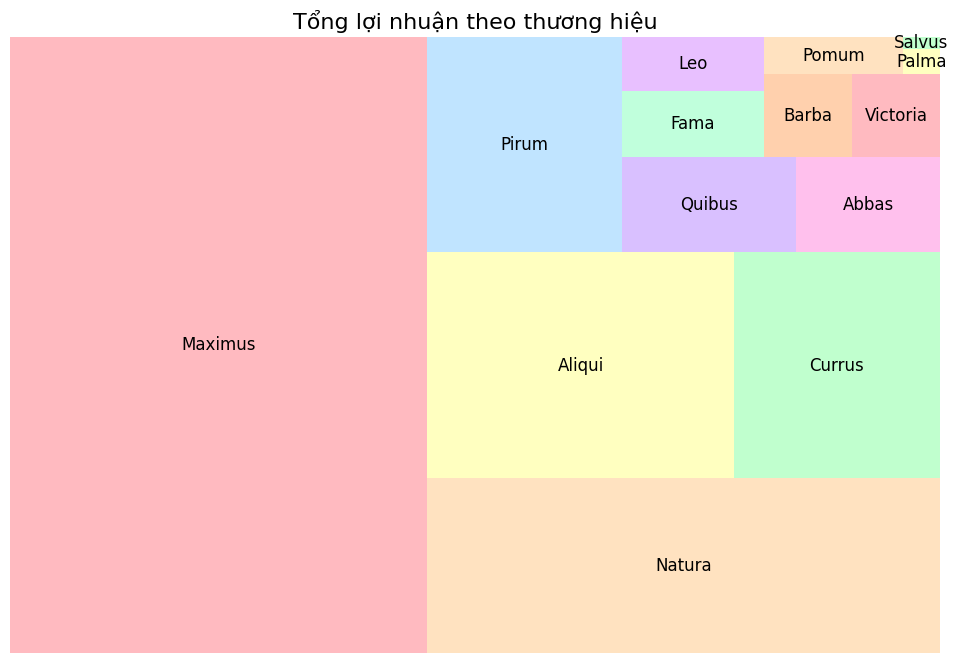

In [67]:
import squarify
import matplotlib.pyplot as plt

# Dữ liệu từ df_grouped
labels = product_lines_grouped['BRAND']
sizes = product_lines_grouped['TOTAL_PROFIT']

# Tạo một danh sách màu sắc pastel
colors = [
    "#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9", "#BAE1FF",
    "#D5BAFF", "#FFBAEC", "#BAFFD9", "#E6BAFF", "#FFCBA4"
]

# Nếu số màu ít hơn số label, lặp lại màu
if len(colors) < len(labels):
    from itertools import cycle, islice
    colors = list(islice(cycle(colors), len(labels)))

plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, alpha=0.9, color=colors, text_kwargs={'fontsize':12})
plt.axis('off')
plt.title("Tổng lợi nhuận theo thương hiệu", fontsize=16)
plt.show()
